# Electric Vehicle Analytics Project
## ML-based Range Prediction, Cost per Km, Charging Time, and Recommendation System


In [1]:
from google.colab import files
uploaded = files.upload()   # Select and upload 'electric_vehicles_spec_2025.csv.csv.xlsx'

Saving electric_vehicles_spec_2025_clean(2).csv to electric_vehicles_spec_2025_clean(2).csv


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

## Data Loading & Exploration
We load the cleaned EV dataset and explore its columns, summary statistics, and missing values to understand its structure and quality.

In [28]:
df = pd.read_csv('electric_vehicles_spec_2025_clean(2).csv')
df.head()

,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,fast_charging_power_kw_dc,fast_charge_port,towing_capacity_kg,cargo_volume_l,seats,drivetrain,length_mm,width_mm,height_mm
0,155,37.8,Lithium-ion,192.000000,235.0,156,225,7.0,67.0,CCS,0.000000,185,4,FWD,3673,1683,1518
1,155,37.8,Lithium-ion,192.000000,235.0,149,225,7.0,67.0,CCS,0.000000,185,4,FWD,3673,1683,1518
2,200,50.8,Lithium-ion,102.000000,345.0,158,280,5.9,79.0,CCS,0.000000,360,5,FWD,4187,1779,1557
3,200,50.8,Lithium-ion,102.000000,345.0,158,280,6.2,79.0,CCS,0.000000,360,5,FWD,4187,1779,1557
4,150,60.0,Lithium-ion,485.293478,310.0,156,315,7.5,78.0,CCS,1052.261062,496,5,FWD,4680,1865,1700


In [29]:
print(df.columns.tolist())

['top_speed_kmh', 'battery_capacity_kWh', 'battery_type', 'number_of_cells', 'torque_nm', 'efficiency_wh_per_km', 'range_km', 'acceleration_0_100_s', 'fast_charging_power_kw_dc', 'fast_charge_port', 'towing_capacity_kg', 'cargo_volume_l', 'seats', 'drivetrain', 'length_mm', 'width_mm', 'height_mm']


In [30]:
df.info()
df.isnull().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   top_speed_kmh              478 non-null    int64  
 1   battery_capacity_kWh       478 non-null    float64
 2   battery_type               478 non-null    object 
 3   number_of_cells            478 non-null    float64
 4   torque_nm                  478 non-null    float64
 5   efficiency_wh_per_km       478 non-null    int64  
 6   range_km                   478 non-null    int64  
 7   acceleration_0_100_s       478 non-null    float64
 8   fast_charging_power_kw_dc  478 non-null    float64
 9   fast_charge_port           478 non-null    object 
 10  towing_capacity_kg         478 non-null    float64
 11  cargo_volume_l             478 non-null    object 
 12  seats                      478 non-null    int64  
 13  drivetrain                 478 non-null    object 

,top_speed_kmh,battery_capacity_kWh,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,fast_charging_power_kw_dc,towing_capacity_kg,seats,length_mm,width_mm,height_mm
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000
mean,185.487448,74.043724,485.293478,498.012739,162.903766,393.179916,6.882636,125.008386,1052.261062,5.263598,4678.506276,1887.359833,1601.125523
std,34.252773,20.331058,919.362209,239.682853,34.317532,103.287335,2.730696,58.143969,717.460849,1.003961,369.210573,73.656807,130.754851
min,125.000000,21.300000,72.000000,113.000000,109.000000,135.000000,2.200000,29.000000,0.000000,2.000000,3620.000000,1610.000000,1329.000000
25%,160.000000,60.000000,216.000000,310.000000,143.000000,320.000000,4.800000,80.000000,500.000000,5.000000,4440.000000,1849.000000,1514.000000
50%,180.000000,76.150000,396.000000,437.500000,155.000000,397.500000,6.600000,113.000000,1052.261062,5.000000,4720.000000,1890.000000,1596.000000
75%,201.000000,90.600000,485.293478,679.000000,177.750000,470.000000,8.200000,150.000000,1600.000000,5.000000,4961.000000,1939.000000,1665.000000
max,325.000000,118.000000,7920.000000,1350.000000,370.000000,685.000000,19.100000,281.000000,2500.000000,9.000000,5908.000000,2080.000000,1986.000000


## Feature Engineering
We create new features for EV charging time and cost per kilometer based on battery capacity, charging power, and efficiency. These help users compare real-world practicality and operating expenses of different models.


In [31]:
features = ['battery_capacity_kWh', 'efficiency_wh_per_km', 'top_speed_kmh']
target = 'range_km'
X = df[features]
y = df[target]

## Machine Learning Model
We use a simple linear regression model to predict the range of an electric vehicle using battery capacity, top speed, and efficiency. This gives users a realistic estimate of how far an EV can go on a full charge.


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f} km")

Mean Absolute Error: 27.67 km


In [34]:
df['charging_time_hours'] = df['battery_capacity_kWh'] / df['fast_charging_power_kw_dc']
print(df[['top_speed_kmh', 'charging_time_hours']].sort_values('charging_time_hours').head(5))

     top_speed_kmh  charging_time_hours
473            210             0.295833
356            130             0.319979
340            250             0.345196
337            250             0.345196
345            260             0.345196


In [35]:
electricity_price_per_kWh = 7.5  # Change to your region's value if needed
df['cost_per_km_rs'] = (df['efficiency_wh_per_km'] / 1000) * electricity_price_per_kWh
print(df[['top_speed_kmh', 'cost_per_km_rs']].sort_values('cost_per_km_rs').head(5))

     top_speed_kmh  cost_per_km_rs
98             125          0.8175
107            135          0.8400
103            135          0.8400
105            135          0.8400
99             125          0.8550


## EV Recommendation System
The system suggests vehicles based on minimum range, maximum charging time, and cost preferences set by the user. This helps find the most suitable EVs from the dataset.


In [36]:
min_range_km = 250
max_charging_time_hr = 10
max_cost_per_km_rs = 2.0

recommended = df[
    (df['range_km'] >= min_range_km) &
    (df['charging_time_hours'] <= max_charging_time_hr) &
    (df['cost_per_km_rs'] <= max_cost_per_km_rs)
]

# Use available columns! If you have 'brand' and 'model', use both, otherwise just display the columns you have.
print(recommended[['top_speed_kmh', 'range_km', 'charging_time_hours', 'cost_per_km_rs']].head(5))

   top_speed_kmh  range_km  charging_time_hours  cost_per_km_rs
2            200       280             0.643038           1.185
3            200       280             0.643038           1.185
4            150       315             0.769231           1.170
5            160       350             0.769231           1.125
6            150       320             0.597647           0.960


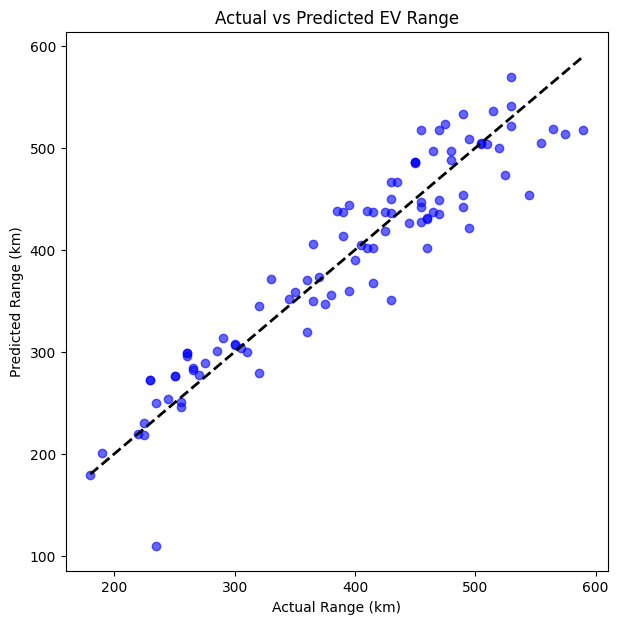

In [37]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.xlabel('Actual Range (km)')
plt.ylabel('Predicted Range (km)')
plt.title('Actual vs Predicted EV Range')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

## Conclusion
We successfully predicted EV range using ML, calculated real-world charging time and cost per km, and built a recommendation system. Further improvements could include more feature analysis, advanced models, and user-interface integration.

## Interpretation of Results & Next Steps
Our model gives a prediction error of about 27 km. Charging time and cost analysis can guide users in their purchase decision. For future improvements, we could explore more advanced models, add more features, or create interactive dashboards.
